In [1]:
import os
import json
import wandb
import subprocess
import random
from tqdm import tqdm
from PIL import Image
import torch
import numpy as np
import io
from openai import OpenAI
import base64
from pydantic import BaseModel
import sys

sys.path.append("..")
# %%
import torch
from sd_pipeline_train import StableDiffusion3Pipeline
from diffusers import StableDiffusion3Pipeline as StableDiffusion3PipelineVanilla

from sd_processor import JointAttnProcessor2_0
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]


In [2]:
positive_prompt = ["a wide sandy beach under a sunny sky",
                   "a beautiful Canada landscape, in bob ross style, with a river, mountains",
                   "A quiet reading room with rows of wooden shelves, cozy armchairs and large windows letting in soft daylight, evoking a tranquil and studious atmosphere for visitors.",
                   "A bustling cityscape at dusk with neon lights illuminating the streets, view from a pedestrian bridge",
                   "A modern kitchen, sleek countertops, spacious island, large windows, bright and airy, minimalist design, ready for culinary activities."]
negative_prompt = ["ocean"
                  "trees",
                  "book",
                  "cars",
                  "faucets"]

In [3]:
from adapter import Adapter
adapter = Adapter()
adapter.train_init()

Loss: 0.008393089286983013


In [4]:
seed = 10
idx = 2
for param in pipe.transformer.parameters():
    param.requires_grad = False
    
for param in adapter.parameters():
    param.requires_grad = True
    
for block in pipe.transformer.transformer_blocks:
    block.attn.processor.neg_prompt_len=max([
        len(pipe.tokenizer.tokenize(negative_prompt[idx])), 
        len(pipe.tokenizer_2.tokenize(negative_prompt[idx])),
        len(pipe.tokenizer_3.tokenize(negative_prompt[idx]))
    ]) + 1 
pipe.transformer.enable_gradient_checkpointing()
image_ours = pipe(
    positive_prompt[idx],
    negative_prompt=negative_prompt[idx],
    num_inference_steps=12,
    generator=torch.manual_seed(seed),
    adapter=adapter.cuda(),
).images


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


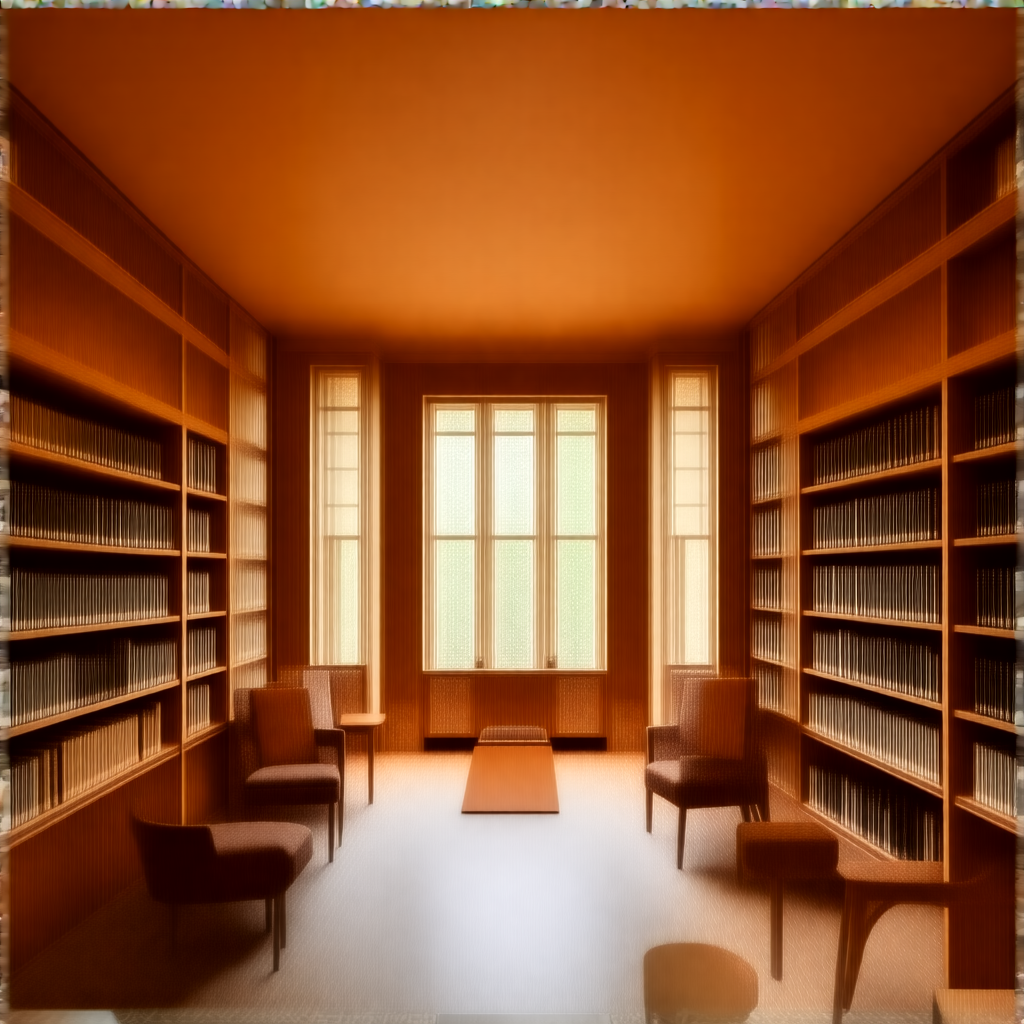

In [5]:
Image.fromarray((image_ours[0].permute(1, 2, 0).detach().float().cpu().numpy() * 255).astype(np.uint8))

In [6]:
image_ours[0].mean().backward()

In [7]:
adapter.conv1.weight.grad

tensor([[[[-6.1388e-04, -1.4151e-03,  1.3557e-03],
          [-2.6656e-04, -8.0353e-04, -1.4761e-03],
          [-2.1931e-03, -1.8003e-03,  2.2327e-04]],

         [[-2.4583e-04,  1.5452e-03, -2.2637e-03],
          [-1.2837e-03, -2.1778e-03, -9.3141e-04],
          [-1.4818e-03, -2.1008e-03,  1.7525e-03]],

         [[-1.3972e-03,  1.9033e-03, -1.0827e-03],
          [-3.6074e-04, -2.4680e-03, -1.7612e-03],
          [ 2.0219e-03,  1.4902e-03,  2.1509e-03]],

         ...,

         [[ 6.2461e-04,  1.8379e-03,  1.4198e-03],
          [-1.8456e-03,  3.1889e-04, -1.7842e-03],
          [-1.7620e-03,  1.2963e-03, -2.3728e-05]],

         [[ 1.4031e-03,  1.2541e-03, -1.8053e-03],
          [-2.0520e-03, -1.5720e-03, -9.8041e-04],
          [-4.2830e-04, -1.6041e-03, -2.1110e-03]],

         [[-8.3888e-03, -8.4220e-03, -8.3742e-03],
          [-8.4375e-03, -8.4707e-03, -8.4223e-03],
          [-8.4097e-03, -8.4428e-03, -8.3945e-03]]],


        [[[ 2.3872e-02,  2.3881e-02,  2.3837e-02],
  